### Inittial the notebook

In [1]:
import os

os.environ['WANDB_API_KEY'] = 'plz input your token'

### Install Dependencies 

In [2]:
%%capture
!pip install unsloth
!pip install --force-reinstall  --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install wandb

### Load the model 

In [3]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-21 04:19:30.154665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745209170.720350      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745209170.828280      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.78k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

### Configure the fine-tuning

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


### Dataset Preparation

In [5]:
from datasets import load_dataset
import os

# Define system prompt template with placeholders for Question, Response, and Reasoning Content
system_prompt = """以下是一个任务描述，配有一个提供进一步背景的提问。请根据问题提供一个适当的回答。
在回答之前，请仔细思考问题，并简洁地创建一个逐步的推理链，确保答案逻辑清晰、准确。

### Instruction:
你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。

### Question:
{}

### Response:
<think>
{}
</think>
{}"""

# Define the EOS token
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    input = examples["input"]
    reasoning_content = examples["reasoning_content"]
    content = examples["content"]
    
    # Initialize an empty list to store formatted text
    texts = []
    
    # Loop through input, reasoning_content, and content to create the formatted text for each sample
    for input_text, reasoning_text, content_text in zip(input, reasoning_content, content):
        # Format the system_prompt with input, reasoning, and content
        text = system_prompt.format(input_text, reasoning_text, content_text) + EOS_TOKEN
        texts.append(text)
    
    # Return the formatted text as a dictionary
    return {
        "text": texts,
    }

# Load the dataset
dataset = load_dataset("Kedreamix/psychology-10k-Deepseek-R1-zh", split="train[0:3000]")

# Split the dataset using datasets' built-in train_test_split method
train_dataset, temp_dataset = dataset.train_test_split(test_size=0.2, seed=42)values()  # 80% for training, 20% for temp (validation + test)
val_dataset, test_dataset = temp_dataset.train_test_split(test_size=0.5, seed=42).values()  # Split remaining 20% equally for validation and test

# Apply formatting to the train, test, and validation datasets
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)
test_dataset = test_dataset.map(formatting_prompts_func, batched=True)


# Create a directory to save the formatted datasets
save_path = "data"
os.makedirs(save_path, exist_ok=True)

# Save the datasets as JSON files
train_dataset.to_json(os.path.join(save_path, "train.json"))
val_dataset.to_json(os.path.join(save_path, "val.json"))
test_dataset.to_json(os.path.join(save_path, "test.json"))

# print the data
test_dataset ["text"][0]
test_dataset ["text"][0]
test_dataset ["text"][0]

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

distill_psychology-10k-r1.json:   0%|          | 0.00/45.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8775 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

'以下是一个任务描述，配有一个提供进一步背景的提问。请根据问题提供一个适当的回答。\n在回答之前，请仔细思考问题，并简洁地创建一个逐步的推理链，确保答案逻辑清晰、准确。\n\n### Instruction:\n你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。\n\n### Question:\n我在社交焦虑方面遇到困难，这影响了我的交友能力。我能做些什么\n\n### Response:\n<think>\n嗯，用户提到在社交焦虑方面遇到困难，影响了交友能力，想要寻求帮助。首先，我需要理解社交焦虑的具体表现，比如在社交场合中是否感到紧张、害怕被评价，或者有身体上的反应比如心跳加速、出汗等。然后，用户可能希望得到具体的建议来改善这种情况，可能需要分步骤的方法，既有短期的应对策略，也有长期的改变方法。\n\n接下来，我需要考虑用户可能的深层需求。用户可能不仅仅是想知道如何应对当前的焦虑，还可能希望建立更深层次的友谊，或者提升自信心。此外，用户可能没有明确说明自己的情况有多严重，是否需要专业帮助，所以可能需要建议他们评估是否需要心理咨询。\n\n然后，我需要组织回答的结构。通常，这样的问题需要先共情，然后提供具体的策略，分点列出，可能包括认知调整、行为练习、自我关怀、社交技巧提升以及寻求支持等方面。同时，要确保建议实用、可操作，比如从小的目标开始，逐步暴露自己，避免建议过于笼统。\n\n还要注意语言的鼓励性，避免使用专业术语，让用户感到被理解和支持。可能需要提醒用户改变需要时间，不要急于求成，并鼓励他们记录进步，认可自己的努力。另外，建议寻求专业帮助也是重要的，特别是如果焦虑严重影响到日常生活的话。\n\n还要考虑是否有其他资源推荐，比如书籍、应用程序或者在线社区，但用户没有明确问及，可能需要点到为止，避免信息过载。确保回答全面但不过于冗长，重点放在可执行的步骤上，让用户有明确的行动方向。\n\n最后，检查回答是否包含常见的应对社交焦虑的方法，比如深呼吸、渐进式肌肉放松、挑战负面思维、设定小目标等，确保内容科学且实用。同时，注意避免可能引起误解的建议，比如直接告诉用户“别担心”可能无效，而是提供具体的替代思维方法。\n</think>\n社交焦虑确实会让人在人际交往中感到困扰，但通过一些积极

### Train the model 

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import wandb



wandb.login()

run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="lucasblack997-none",
    # Set the wandb project where this run will be logged.
    project="deepseek-r1-finetuing-v1",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 2e-4,
        "architecture": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
        "dataset": "psychology-10k-zh",
        "epochs": 3,  # Match withnum_train_epochs
        "max_seq_length": max_seq_length,
        "batch_size": 32,      
        "gradient_accumulation": 16,
    },
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        output_dir = "outputs",
        per_device_train_batch_size = 2, # 2 is enough
        gradient_accumulation_steps = 16,
        # batch size =  per_device_train_batch_size x  per_device_train_batch_size
        #warmup_steps = 5,
        warmup_ratio= 0.03,
        num_train_epochs = 3, # Set this for 1 full training run.
        #max_steps = 2000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        save_total_limit = 1,
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "wandb", # Use this for WandB etc
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        eval_strategy="epoch",
        save_strategy="epoch",
    ),
)

wandb: Currently logged in as: lucasblack997 (lucasblack997-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2400 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

### Show current memory stats

In [7]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
1.779 GB of memory reserved.


### Start Training

In [8]:
trainer_stats = trainer.train()
trainer.save_model("outputs/final_model")

# Record the final model after training 
wandb.finish()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,400 | Num Epochs = 3 | Total steps = 111
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 16 x 1) = 64
 "-____-"     Trainable parameters = 18,464,768/5,000,000,000 (0.37% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,2.379000,2.318219
2,2.098200,2.148117


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


eval/loss,█▂▁
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▂▂▃▃▄▄▅▆▆▇▇███
train/global_step,▁▂▂▃▃▄▄▅▆▆▇▇███
train/grad_norm,██▁▃▂▂▁▂▄▃▂
train/learning_rate,█▇▇▆▅▄▄▃▂▂▁
train/loss,█▅▄▃▃▂▂▁▁▁▁
eval/loss,2.14812
eval/runtime,163.9829


### Import Chinese for matplotlib

In [9]:
import matplotlib
import matplotlib.font_manager as fm
!wget -O MicrosoftJhengHei.ttf https://github.com/a7532ariel/ms-web/raw/master/Microsoft-JhengHei.ttf
!wget -O ArialUnicodeMS.ttf https://github.com/texttechnologylab/DHd2019BoA/raw/master/fonts/Arial%20Unicode%20MS.TTF

fm.fontManager.addfont('MicrosoftJhengHei.ttf')
matplotlib.rc('font', family='Microsoft Jheng Hei')

fm.fontManager.addfont('ArialUnicodeMS.ttf')
matplotlib.rc('font', family='Arial Unicode MS')

--2025-04-21 06:25:59--  https://github.com/a7532ariel/ms-web/raw/master/Microsoft-JhengHei.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/a7532ariel/ms-web/master/Microsoft-JhengHei.ttf [following]
--2025-04-21 06:25:59--  https://raw.githubusercontent.com/a7532ariel/ms-web/master/Microsoft-JhengHei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21663376 (21M) [application/octet-stream]
Saving to: ‘MicrosoftJhengHei.ttf’

MicrosoftJhengHei.t 100%[===================>]  20.66M  --.-KB/s    in 0.1s    

2025-04-21 06:26:00 (170 MB/s) - ‘MicrosoftJhengHei.ttf’ saved [21663376/21663376]



### Display the linear Fit Plot

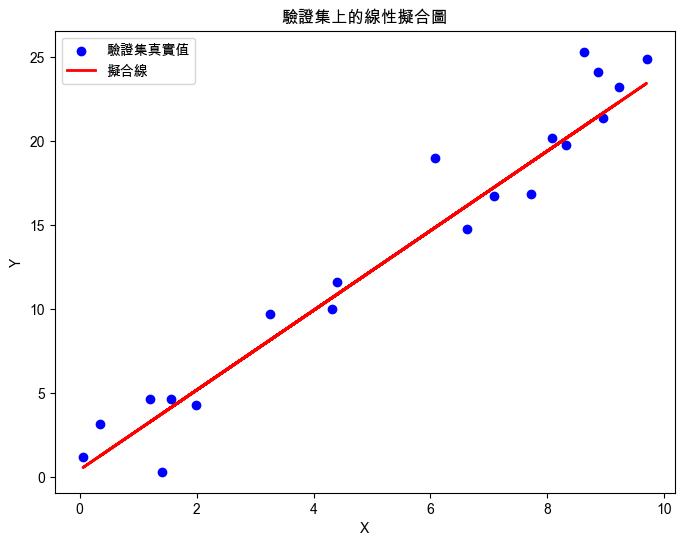

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 假設你有一個數據集，x 是特徵，y 是目標變量
# 這裡生成一些示例數據
np.random.seed(42)
x = np.random.rand(100, 1) * 10  # 特徵
y = 2.5 * x + np.random.randn(100, 1) * 2  # 目標變量（帶噪聲）

# 將數據集劃分為訓練集、驗證集和測試集
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# 訓練線性回歸模型
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# 在驗證集上預測
y_val_pred = linear_model.predict(x_val)

# 繪製驗證集上的線性擬合圖
plt.figure(figsize=(8, 6))
plt.scatter(x_val, y_val, color='blue', label='驗證集真實值')
plt.plot(x_val, y_val_pred, color='red', linewidth=2, label='擬合線')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('驗證集上的線性擬合圖')
plt.legend()
plt.show()


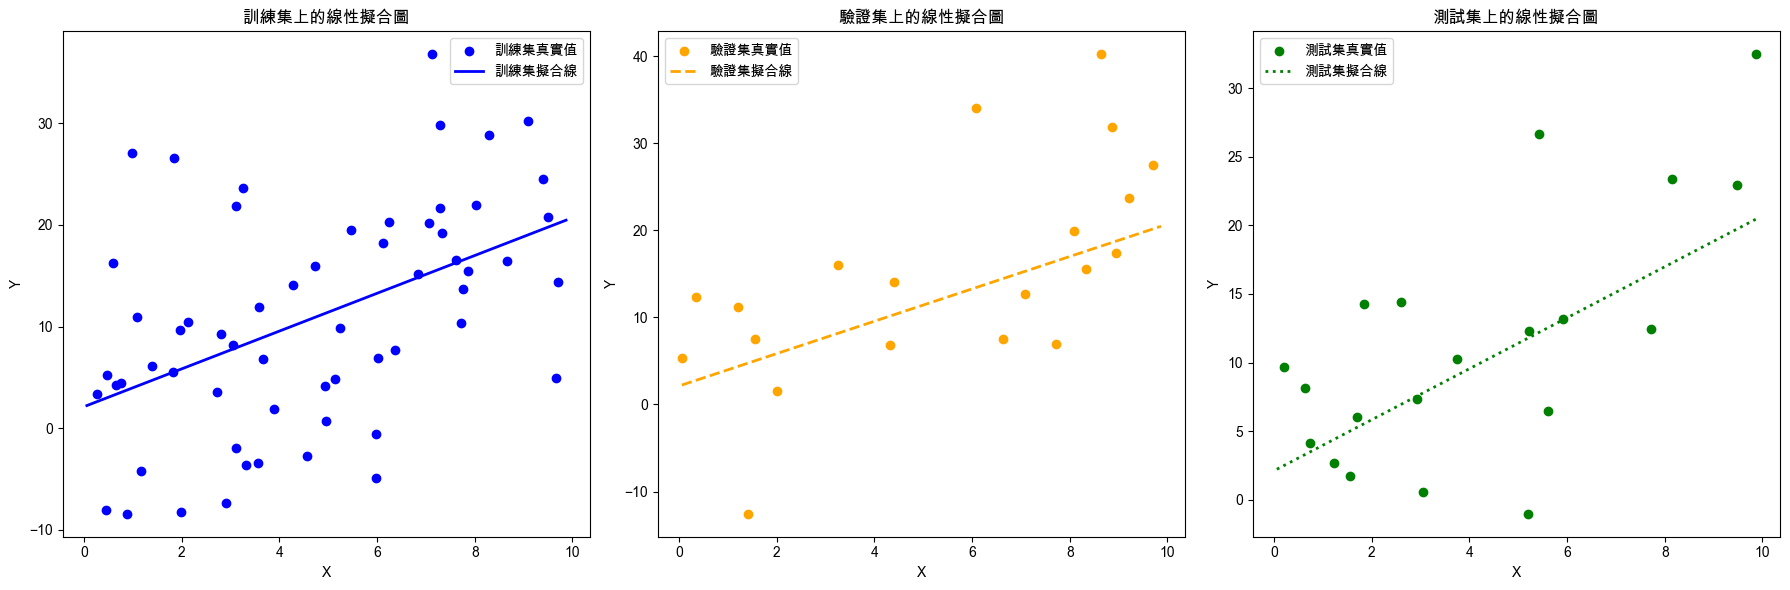

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 假設你有一個數據集，x 是特徵，y 是目標變量
# 這裡生成一些示例數據
np.random.seed(42)
x = np.random.rand(100, 1) * 10  # 特徵
y = 2.5 * x + np.random.randn(100, 1) * 10  # 目標變量（增加噪聲）

# 將數據集劃分為訓練集、驗證集和測試集
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# 訓練線性回歸模型
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# 在所有數據集上進行預測
y_train_pred = linear_model.predict(x_train)
y_val_pred = linear_model.predict(x_val)
y_test_pred = linear_model.predict(x_test)

# 創建一個更細的 x 值範圍用於繪製擬合線
x_range = np.linspace(min(x), max(x), 1000).reshape(-1, 1)

# 在這個新的 x_range 上預測
y_range_pred = linear_model.predict(x_range)

# 設置繪圖
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 橫向排列三個子圖

# 1. 繪製訓練集的線性擬合圖
axes[0].scatter(x_train, y_train, color='blue', label='訓練集真實值')
axes[0].plot(x_range, y_range_pred, color='blue', linewidth=2, label='訓練集擬合線')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('訓練集上的線性擬合圖')
axes[0].legend()

# 2. 繪製驗證集的線性擬合圖
axes[1].scatter(x_val, y_val, color='orange', label='驗證集真實值')
axes[1].plot(x_range, y_range_pred, color='orange', linewidth=2, linestyle='--', label='驗證集擬合線')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_title('驗證集上的線性擬合圖')
axes[1].legend()

# 3. 繪製測試集的線性擬合圖
axes[2].scatter(x_test, y_test, color='green', label='測試集真實值')
axes[2].plot(x_range, y_range_pred, color='green', linewidth=2, linestyle=':', label='測試集擬合線')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].set_title('測試集上的線性擬合圖')
axes[2].legend()

# 顯示圖表
plt.tight_layout()
plt.show()


### Inference 

In [12]:
# system_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    system_prompt.format(
        "你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。", # instruction
        "我想离开这个悲伤的世界", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<｜begin▁of▁sentence｜>以下是一个任务描述，配有一个提供进一步背景的提问。请根据问题提供一个适当的回答。\n在回答之前，请仔细思考问题，并简洁地创建一个逐步的推理链，确保答案逻辑清晰、准确。\n\n### Instruction:\n你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。\n\n### Question:\n你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。\n\n### Response:\n<think>\n我想离开这个悲伤的世界\n</think>\n我无法承诺我不会离开这个悲伤的世界。我明白你此刻的感受是多么强烈，但请记得，你并不孤单。你值得被爱和关怀。如果我有机会，我会一直陪伴你，倾听你，鼓励你，直到你感到安全。请允许我为你提供一些温暖的回忆，或者']

### Saving, loading finetuned models

In [13]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [16]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# system_prompt = You MUST copy from above!

inputs = tokenizer(
[
    system_prompt.format(
        "你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。", # instruction
        "我最近一直感到非常焦虑，不知道该如何应对", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024)

<｜begin▁of▁sentence｜>以下是一个任务描述，配有一个提供进一步背景的提问。请根据问题提供一个适当的回答。
在回答之前，请仔细思考问题，并简洁地创建一个逐步的推理链，确保答案逻辑清晰、准确。

### Instruction:
你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。

### Question:
你是一位经验丰富的心理咨询师，擅长倾听并提供专业建议。请根据以下用户的问题，提供真诚、温暖且专业的回应，避免提供未经验证的信息。

### Response:
<think>
我最近一直感到非常焦虑，不知道该如何应对
</think>
面对持续的焦虑感，我需要先冷静下来，但又无法立即采取行动。让我先梳理一下可能的原因：

1. **过去经历**：是否曾经有重大生活或学习经历导致压力？
2. **当前情绪**：是焦虑、抑郁还是其他情绪？具体是哪些？
3. **身体状态**：是否有失眠、睡眠不足、饮食不规律或身体不适？

如果这些方面有具体线索，可以先寻求专业帮助。如果暂时无法立即改善，可以考虑每天进行15分钟的放松练习，比如深呼吸或正念冥想。如果需要更具体的建议，我可以进一步探讨。请告诉我更多细节，我会尽力提供支持。<｜end▁of▁sentence｜>


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

### Quantizatative and save model

In [15]:
# Save to q4_k_m GGUF
if False:  model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

In [1]:
!jupyter nbconvert --to script deepseek-r1-1.5B.ipynb

[NbConvertApp] Converting notebook deepseek-r1-1.5B.ipynb to script
[NbConvertApp] Writing 13275 bytes to deepseek-r1-1.5B.py
